In [1]:
import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.layers import Conv2D, Activation, BatchNormalization, Input, Dropout
from keras.layers import AveragePooling2D, Flatten, MaxPooling2D, Dense
from keras.models import Model
import keras

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
num_classes = 10
batch_size = 100
epochs = 10
steps_per_epoch =  int(40000/batch_size)

train_x shape: (40000, 32, 32, 3)
40000 train samples


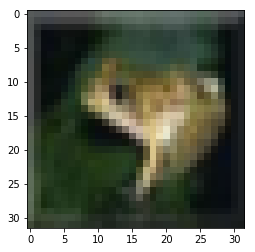

In [3]:
def load_data():
    # Modify path string. use your path which your dataset is in
    path =  r'C:\Users\strea\Links\baseline_code_final (2)'
    fpath = os.path.join(path, 'train_data')
    
    with open(fpath, 'rb') as f:
        d = cPickle.load(f, encoding='bytes')
    X_train = d['data']
    y_train = d['labels']
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32) # 3072개 숫자가 한줄로 이어진 배열 하나를 32x32짜리 배열 3개로 만듦
    X_train = X_train.transpose(0, 2, 3, 1)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

train_x, train_y = load_data()
print('train_x shape:', train_x.shape)
print(train_x.shape[0], 'train samples')
plt.imshow(train_x[5])
plt.show()

In [4]:
# random state는 전체 데이터셋에서 train set의 비율을 의미함 0~1 사이의 값을 입력함
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, random_state=0)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((30000, 32, 32, 3), (10000, 32, 32, 3), (30000, 10), (10000, 10))

In [7]:
def simple_net(x):
    for i in range(3):
        x = Conv2D(32,(3,3), padding='same')(x)
        x = Activation('elu')(x)
        x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.2)(x)
    return x

In [8]:
inputs = Input(shape=x_train.shape[1:]) # 텐서로 만들어줌
x = simple_net(inputs)
x = AveragePooling2D(pool_size=2)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activat

In [9]:
opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)    
model.compile(loss='categorical_crossentropy',
              optimizer=opt_rms,
              metrics=['accuracy'])

In [10]:
# data augmentation

datagen = ImageDataGenerator()

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     )

datagen.fit(x_train)

In [11]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    workers=4)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
400/400 [==============================] - 14s 35ms/step - loss: 1.5248 - acc: 0.4721
Epoch 2/10
400/400 [==============================] - 12s 29ms/step - loss: 1.1146 - acc: 0.6130
Epoch 3/10
400/400 [==============================] - 11s 29ms/step - loss: 0.9938 - acc: 0.6553
Epoch 4/10
400/400 [==============================] - 11s 29ms/step - loss: 0.9048 - acc: 0.6854
Epoch 5/10
400/400 [==============================] - 11s 29ms/step - loss: 0.8435 - acc: 0.7062
Epoch 6/10
400/400 [==============================] - 11s 29ms/step - loss: 0.8108 - acc: 0.7185
Epoch 7/10
400/400 [==============================] - 12s 29ms/step - loss: 0.7483 - acc: 0.7391
Epoch 8/10
400/400 [==============================] - 12s 29ms/step - loss: 0.7306 - acc: 0.7448 0s - loss: 0.7307 - acc: 0.744
Epoch 9/10
400/400 [==============================] - 12s 29ms/step - loss: 0.6984 - acc: 0.7555 1
Epoch 10/10
400/400 [=========================

## batch size 및 data augmentation 파라미터 유무 차이

초기모델 : batch_size = 1000, epochs = 10, train=3만, test=1만, conv(32,(3,3),same) + elu + averagepool(size=2) + flatten = output(numclass, softmax, henorm)

In [10]:
#testing - from keras docs
# scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
# print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 55us/step

Test result: 41.780 loss: 1.705


add data augement parameters - 같은 조건에 학습 시간이 확 늘어남 / epoch 10만 돌렸을때는 성능 더 안 좋아짐

In [10]:
# scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
# print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 59us/step

Test result: 38.820 loss: 1.750


data augmentation 파라미터 지우고 batch size 100으로 줄임

In [16]:
# scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
# print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 56us/step

Test result: 40.050 loss: 1.732


다시 augmentation 파라미터 넣고 돌림 / batch size 100 - epoch당 평균 15s

In [19]:
# scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
# print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 0s 47us/step

Test result: 44.510 loss: 1.574


다시 파라미터 지우고 batch 10으로 줄임 - epoch당 26s

In [23]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 0s 46us/step

Test result: 48.480 loss: 1.527


다시 augmentation 파라미터 넣고 돌림 / batch size 10 - epoch당 평균 17s

In [26]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 0s 46us/step

Test result: 48.500 loss: 1.482


In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 57us/step

Test result: 42.070 loss: 1.638


restart 하고, datagen 하면서 다시 batch 100으로 늘림 - 평균 14초

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# 아까 100에 argument 넣은거 결과가 44.510  / 1.574 였음

10000/10000 [==============================] - 1s 57us/step

Test result: 40.770 loss: 1.718


restart 하고 파라미터 빼고 batch 100 - 평균 7초

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# 아까 100에 argument 넣은거 결과가  40.050 / 1.732 였음

10000/10000 [==============================] - 1s 57us/step

Test result: 41.060 loss: 1.699


## epoch 늘리면서 / augmentation 파라미터 유무 

batch_size = 100, epochs = 20, 파라미터 x

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 56us/step

Test result: 44.030 loss: 1.612


batch_size = 10, epochs = 100, 파라미터 x - 하나당 27s 

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 61us/step

Test result: 47.870 loss: 1.837


batch_size = 10, epochs = 100, 파라미터 0 - 하나당 27s 

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 60us/step

Test result: 46.380 loss: 1.530


## conv, activation 반복 횟수 + batch norm 유무

batch_size = 100, epochs = 10, 파라미터 x, conv에 activation 3번 반복함  - 하나당 8초

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 94us/step

Test result: 59.470 loss: 1.293


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + <b>batch norm</b> 3번 반복함  - 하나당 11초

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# loss: 0.2286 - acc: 0.9253 배치norm 했더니 과적합됨

10000/10000 [==============================] - 1s 117us/step

Test result: 61.420 loss: 1.733


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation 5번 반복함 - 12s

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 120us/step

Test result: 61.500 loss: 1.617


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + <b>batch norm</b> 5번 반복함 - 17s

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# loss: 0.1297 - acc: 0.9581

10000/10000 [==============================] - 2s 167us/step

Test result: 63.840 loss: 1.900


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation 7번 반복함 - 16s

In [13]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 152us/step

Test result: 60.740 loss: 1.881


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation  + <b>batch norm</b>  7번 반복함 - 24s

In [12]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# loss: 0.1005 - acc: 0.9670  batch는 과적합 일어남

10000/10000 [==============================] - 2s 211us/step

Test result: 65.930 loss: 1.801


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation 9번 반복함 - 22s

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# loss: 0.2685 - acc: 0.9048 과적합이 일어나는거 같음 

10000/10000 [==============================] - 2s 232us/step

Test result: 61.070 loss: 1.864


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation <b>20</b>번 반복함 - 22s

In [13]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# 학습이 전혀 안 됨

10000/10000 [==============================] - 3s 340us/step

Test result: 9.940 loss: 14.516


## batch 랑 activation이랑 자리 바꿔봄

batch_size = 100, epochs = 10, 파라미터 x, conv에  + <b>batch norm</b> + activation 3번 반복함 

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# Test result: 61.420 loss: 1.733 배치가 뒤에 있을 때

10000/10000 [==============================] - 1s 117us/step

Test result: 59.740 loss: 1.549


batch_size = 100, epochs = 10, 파라미터 x, conv에  + <b>batch norm</b> + activation 5번 반복함 

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# Test result: 63.840 loss: 1.900 배치가 뒤에 있을 때

10000/10000 [==============================] - 2s 166us/step

Test result: 63.770 loss: 1.447


batch_size = 100, epochs = 10, 파라미터 x, conv에  + <b>batch norm</b> + activation 7번 반복함 

In [12]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# Test result: 65.930 loss: 1.801 배치가 뒤에 있을 때

10000/10000 [==============================] - 2s 211us/step

Test result: 64.190 loss: 1.481


결론 - activation 한 뒤에 batch 하는게 더 나음

## maxpooling(2,2)랑 dropout(0.2)

batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 3번 반복함 + <b>maxpooling(2,2)</b>

In [14]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 116us/step

Test result: 68.140 loss: 1.020


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 3번 반복함 + maxpooling(2,2) + <b>dropout(0.2)</b>

In [12]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 119us/step

Test result: 67.290 loss: 0.985


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 5번 반복함  + <b>maxpooling(2,2)</b>

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 165us/step

Test result: 67.600 loss: 1.070


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 5번 반복함 + maxpooling(2,2) + <b>dropout(0.2)</b>

In [15]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 168us/step

Test result: 71.310 loss: 0.889


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 7번 반복함 + <b>maxpooling(2,2)</b>

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# 처음으로 70점 넘음

10000/10000 [==============================] - 2s 216us/step

Test result: 72.140 loss: 0.896


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 7번 반복함 + maxpooling(2,2) + <b>dropout(0.2)</b>

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 220us/step

Test result: 72.440 loss: 0.877


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 9번 반복함 + <b>maxpooling(2,2)</b> 

In [15]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 3s 258us/step

Test result: 73.770 loss: 0.869


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 9번 반복함 + maxpooling(2,2) + <b>dropout(0.2)</b>

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 3s 263us/step

Test result: 75.000 loss: 0.758


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 11번 반복함 + <b>maxpooling(2,2)</b> - 35s

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# loss: 0.3897 - acc: 0.8634  // 과적합 조금은 막아줌

10000/10000 [==============================] - 3s 309us/step

Test result: 73.550 loss: 0.878


batch_size = 100, epochs = 10, 파라미터 x, conv에 activation + batch norm 11번 반복함 + maxpooling(2,2) + <b>dropout(0.2)</b> - 36s

In [12]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 3s 298us/step

Test result: 71.800 loss: 0.879


## 종합 테스트

batch_size = 10, epochs = 100, 파라미터 x, conv에 activation 3번 반복함, 인자 x

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 93us/step

Test result: 54.400 loss: 6.453
